Text(0.5,1,'undistorted/wrapped Image')

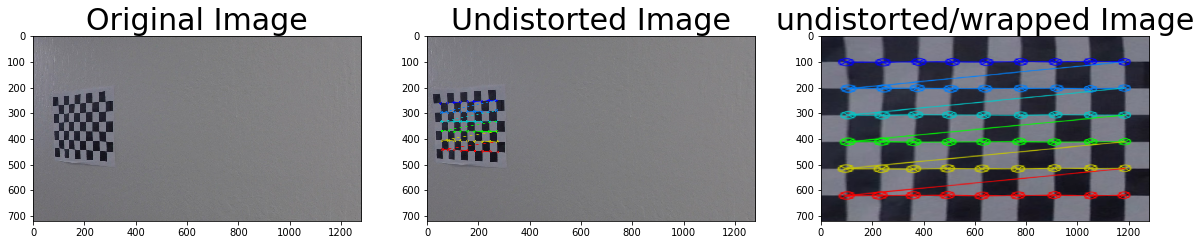

In [48]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import glob
%matplotlib inline

#first part of the rubric, chessboard files.


# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y


def calc_objimg_points(images,nx,ny):
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    return objpoints, imgpoints
    
    
def undistort(img, objpoints, imgpoints,nx, ny):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist =  cv2.undistort(img, mtx, dist, None, mtx)
    return undist


#Function from the course should work fine.:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img,nx, ny): #nx, ny, mtx, dist):
    # function as from the lesson, with small modification
    
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = img.shape[1::-1]

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(img, M, img_size)
    else: #could not find, so return 
        print("could not find corners, so returning orginal image")
        warped=img
        M=None
    # Return the resulting image and matrix
    return warped, M


#load multiple pictures to get distort data
images = glob.glob('camera_cal/*.jpg')
objpoints, imgpoints = calc_objimg_points(images,nx,ny)
image=cv2.imread(images[np.random.randint(len(images)-1)])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undist = undistort(image, objpoints, imgpoints,nx, ny)
unwrapedImage, m=  corners_unwarp(undist,nx, ny)

# Visualize undistortion
                               
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
ax3.imshow(unwrapedImage)
ax3.set_title('undistorted/wrapped Image', fontsize=30)

Text(0.5,1,'warped Image')

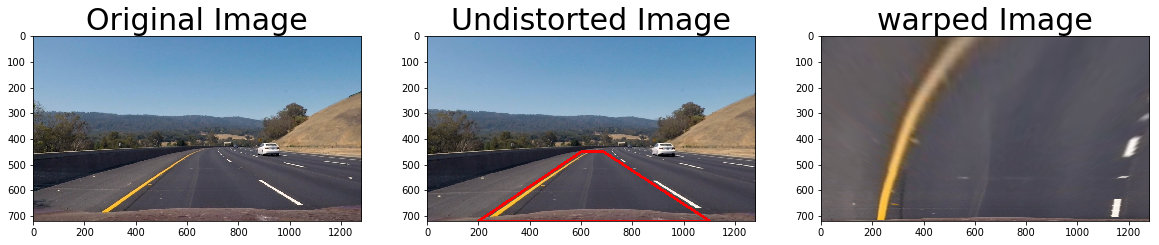

In [97]:
#second part
#Here we read the test image and apply the undist calculated in part 1.
#Then we draw some lines that will be used to wrap it.
def corners_unwarp_road(img):
    src=np.float32([[200,720],[600,450],[687,450],[1100,720]])
    dst=np.float32([[200,720],[200,0],[1100,0],[1100,720]])
    M = cv2.getPerspectiveTransform(src, dst)
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = img.shape[1::-1]
    warped = cv2.warpPerspective(img, M, img_size)
    return warped
    
#images = glob.glob('test_images/*.jpg')
#images  = cv2.imread(images)#[np.random.randint(len(images)-1)])
#read all files and convert to rgb
images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in glob.glob('test_images/*.jpg')]
imageIndex=np.random.randint(len(images)-1)
undist=np.zeros_like(images)
for i,image in enumerate(images):
    undist[i] = undistort(image, objpoints, imgpoints,nx, ny)



src=np.array([[200,720],[1100,720],[687,450],[600,450]], np.int32)
src = src.reshape((-1,1,2))
undist_line=cv2.polylines(undist[imageIndex].copy(), [src], True,(255,0,0),thickness=10)  
warped=corners_unwarp_road(undist[imageIndex])
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(images[imageIndex])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_line)
ax2.set_title('Undistorted Image', fontsize=30)
ax3.imshow(warped)
ax3.set_title('warped Image', fontsize=30)


In [85]:
#Third part, use images above and apply sobel and some other stuff to
#create a binary image
from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets
from ipywidgets import widgets

def test(ksize,xthresh_min,xthresh_max,ythresh_min,ythresh_max,magthresh_min,
         magthresh_max,dirthresh_min,dirthresh_max,s_thresh_min,s_thresh_max):
    
    
    def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
        #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

        # Return the result
        return binary_output

    def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
        # Convert to grayscale
        #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

        # Return the binary image
        return binary_output

    def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
        # Grayscale
        #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Calculate the x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

        # Return the binary image
        return binary_output
    
    images=undist
    for image in images:
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        gray = image[:,:,0]#cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)# keep only red

        # Apply each of the thresholding functions
        gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(xthresh_min, xthresh_max))
        grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(ythresh_min, ythresh_max))
        mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(magthresh_min, magthresh_max))
        dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(dirthresh_min, dirthresh_max))



        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
        gradyx = np.zeros_like(dir_binary)
        gradyx[((gradx == 1) & (grady == 1))] = 1
        magdir = np.zeros_like(dir_binary)
        magdir[(mag_binary == 1) & (dir_binary == 1)] = 1
        combined = np.zeros_like(dir_binary)
        combined[(gradyx ==1 ) | (magdir == 1) | (s_binary == 1)] = 1
        #combined = np.uint8(255*combined/np.max(combined))
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40,20))
        ax1.imshow(gradyx, cmap='gray')
        ax1.set_title('x', fontsize=10)
        ax2.imshow(magdir, cmap='gray')
        ax2.set_title('y', fontsize=10)

        ax3.imshow(s_binary, cmap='gray')
        ax3.set_title('s', fontsize=10)


        combined=corners_unwarp_road(combined.astype(np.uint8))
        ax4.imshow(combined, cmap='gray')
        ax4.set_title('comb', fontsize=10)

    
    
    #gray = cv2.cvtColor(, cv2.COLOR_RGB2GRAY)#
    #sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    #abs_sobelx = np.absolute(sobelx)
    #scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    #thresh_min = 20
    #thresh_max = 255
    #sxbinary = np.zeros_like(scaled_sobel)
    #sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #plt.imshow(sxbinary, cmap='gray'

interact_manual(test,ksize=widgets.IntSlider(min=1,max=31,step=2,value=15)
    ,xthresh_min=widgets.IntSlider(min=1,max=255,step=1,value=20)
    ,xthresh_max=widgets.IntSlider(min=1,max=255,step=1,value=100)
    ,ythresh_min=widgets.IntSlider(min=1,max=255,step=1,value=20)
    ,ythresh_max=widgets.IntSlider(min=1,max=255,step=1,value=100)
    ,magthresh_min=widgets.IntSlider(min=1,max=255,step=1,value=20)
    ,magthresh_max=widgets.IntSlider(min=1,max=255,step=1,value=100)
    ,dirthresh_min=widgets.FloatSlider(min=0,max=np.pi,step=np.pi/20,value=0.7)
    ,dirthresh_max=widgets.FloatSlider(min=0,max=np.pi,step=np.pi/20,value=1.3)
    ,s_thresh_min=widgets.IntSlider(min=1,max=255,step=1,value=170)
    ,s_thresh_max=widgets.IntSlider(min=1,max=255,step=1,value=255))

        #,ksize=widgets.IntSlider(min=1,max=255,step=1,value=1)
        #,ksize=widgets.IntSlider(min=1,max=255,step=1,value=1));

interactive(children=(IntSlider(value=15, description='ksize', max=31, min=1, step=2), IntSlider(value=20, description='xthresh_min', max=255, min=1), IntSlider(value=100, description='xthresh_max', max=255, min=1), IntSlider(value=20, description='ythresh_min', max=255, min=1), IntSlider(value=100, description='ythresh_max', max=255, min=1), IntSlider(value=20, description='magthresh_min', max=255, min=1), IntSlider(value=100, description='magthresh_max', max=255, min=1), FloatSlider(value=0.7, description='dirthresh_min', max=3.141592653589793, step=0.15707963267948966), FloatSlider(value=1.3, description='dirthresh_max', max=3.141592653589793, step=0.15707963267948966), IntSlider(value=170, description='s_thresh_min', max=255, min=1), IntSlider(value=255, description='s_thresh_max', max=255, min=1), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.test>

In [74]:
image[:,:,1].shape

(720, 1280)